In [1]:
from skimage import data, measure
import skimage as sk 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import minmax_scale
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import measure
import tensorflow as tf
import keras
from keras import layers

import generator
import explainabilityModels

In [3]:
#hyperparameters and blank image and label generation
N = 4000
size = 64
big_blob_size = 8
big_blob_range = 2
labels = np.random.randint(2, size = N)
imgs = np.zeros((size, size, N))


In [5]:
#fill array with corresponding images
for i in range(N):
    if labels[i] == 0:
        x = generator.generate_circles_and_ellipse(ellipse = True, num_blobs=5, img_size=size, maj_axis=12, min_axis=3)
    elif labels[i] == 1:
        x = generator.generate_circles_and_ellipse(ellipse = False, num_blobs=5, img_size=size, maj_axis=12, min_axis=3)
    imgs[:,:,i] = x

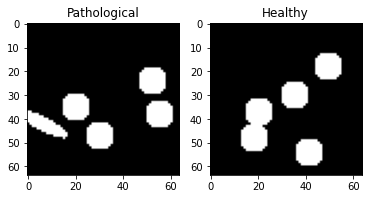

In [12]:
#display one pathological and one healthy image
fig, ax = plt.subplots(1,2)

path_img = imgs[:,:,np.where(labels == 0)[0][0]]
healthy_img = imgs[:,:,np.where(labels ==1)[0][0]]

ax[0].imshow(path_img, cmap=plt.cm.gray)
ax[1].imshow(healthy_img, cmap=plt.cm.gray)

ax[0].set_title("Pathological");
ax[1].set_title("Healthy");

In [13]:
#prepare data for training
from sklearn.model_selection import train_test_split
X = np.expand_dims(imgs, -1)
X = np.transpose(X, (2,1,0,3))
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X.shape

(4000, 64, 64, 1)

In [37]:
# Model hyperparameters
num_classes = 2
input_shape = (size, size, 1)
batch_size = 64
epochs = 15
conv_size=(3,3)
save = True
# convert class vectors to binary class matrices
y_train_cat = keras.utils.to_categorical(y_train, num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes)

In [63]:
#create model

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=conv_size, activation="relu"),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(name="features"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 62, 62, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 62, 62, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 31, 31, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 29, 29, 64)       256       
 hNormalization)                                                 
                                                      

In [64]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.fit(X_train, y_train_cat, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Epoch 1/15
38/38 [==============================] - 5s 121ms/step - loss: 1.8884 - accuracy: 0.5261 - val_loss: 0.6706 - val_accuracy: 0.5784
Epoch 2/15
38/38 [==============================] - 4s 115ms/step - loss: 1.1446 - accuracy: 0.6115 - val_loss: 0.6987 - val_accuracy: 0.5522
Epoch 3/15
38/38 [==============================] - 4s 115ms/step - loss: 1.0206 - accuracy: 0.6646 - val_loss: 1.1154 - val_accuracy: 0.5522
Epoch 4/15
38/38 [==============================] - 4s 117ms/step - loss: 0.7082 - accuracy: 0.7716 - val_loss: 1.3547 - val_accuracy: 0.5522
Epoch 5/15
38/38 [==============================] - 5s 119ms/step - loss: 0.4781 - accuracy: 0.8342 - val_loss: 3.6574 - val_accuracy: 0.5522
Epoch 6/15
38/38 [==============================] - 4s 116ms/step - loss: 0.3057 - accuracy: 0.8951 - val_loss: 7.0843 - val_accuracy: 0.5522
Epoch 7/15
38/38 [==============================] - 4s 115ms/step - loss: 0.1613 - accuracy: 0.9432 - val_loss: 9.3192 - val_accuracy: 0.5522
Epoch 

In [65]:
if save:
    model.save("models/model15_circle_ellipse")

INFO:tensorflow:Assets written to: models/model15_circle_ellipse\assets


INFO:tensorflow:Assets written to: models/model15_circle_ellipse\assets


In [85]:
model = tf.keras.models.load_model("models/model30_circle_ellipse/")

In [86]:
# Validate model
from sklearn.metrics import classification_report

label_names = ['Pathological', 'Healthy']

score = model.evaluate(X_test, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

y_test_pred_DL_full = np.argmax(model.predict(X_test),axis=1) # convert back from one-hot categorical encoding to integers
print(classification_report(y_test, y_test_pred_DL_full, target_names=label_names))

Test loss: 11.42825698852539
Test accuracy: 0.9931818246841431
42/42 [==============================] - 1s 18ms/step
              precision    recall  f1-score   support

Pathological       1.00      0.99      0.99       659
     Healthy       0.99      1.00      0.99       661

    accuracy                           0.99      1320
   macro avg       0.99      0.99      0.99      1320
weighted avg       0.99      0.99      0.99      1320



In [87]:
import ipywidgets as widgets
#get array or predictions for test set

predicted_classes = model.predict(X_test)
predicted_classes = np.argmax(predicted_classes, axis=1)


label_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='True Label:',
)
pred_picker = widgets.Dropdown(
    options=[('Pathological', 0), ('Healthy', 1)],
    value=0,
    description='Predicted Label:',
)
#pick what you want to see
display(label_picker)
display(pred_picker)


42/42 [==============================] - 1s 18ms/step


Dropdown(description='True Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

Dropdown(description='Predicted Label:', options=(('Pathological', 0), ('Healthy', 1)), value=0)

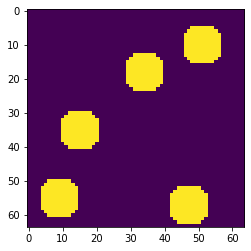

In [96]:
#show image
img = X_test[np.where((y_test == label_picker.value) & (predicted_classes == pred_picker.value))[0][0]]
plt.imshow(img)

In [97]:
#choose explainability options
explain_picker = widgets.SelectMultiple(
    options=['GradCAM', 'Single Blob Occlusion', 'Patch Occlusion', 'Overlapping Patch Occlusion'],
    value=['GradCAM'],
    #rows=10,
    description='Methods',
    disabled=False
)

display(explain_picker)

SelectMultiple(description='Methods', index=(0,), options=('GradCAM', 'Single Blob Occlusion', 'Patch Occlusio…

In [98]:
%%capture
heatmaps = []

for method in explain_picker.value:
    if method == 'GradCAM':
        heatmaps.append(explainabilityModels.make_gradcam_heatmap(img, model, -5))
    elif method == 'Single Blob Occlusion':
        heatmaps.append(explainabilityModels.single_blob_occlusion(img, label_picker.value, model=model)[0])
    elif method == 'Patch Occlusion':
        heatmaps.append(explainabilityModels.occlusion_map(img, label_picker.value, patch_size = 8, model=model))
    elif method == 'Overlapping Patch Occlusion':
        heatmaps.append(explainabilityModels.overlapping_occlusion_map(img, label_picker.value, patch_size=8, step_size = 2, model=model))
        

0


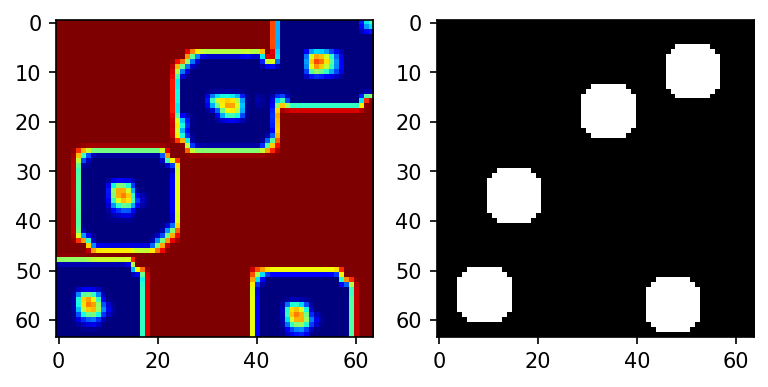

In [99]:
fig, ax = plt.subplots(1, len(heatmaps)+1)
fig.set_dpi(150)
fig.tight_layout
for idx, map in enumerate(heatmaps):
    print(idx)
    ax[idx].imshow(map, cmap=plt.cm.jet)

ax[-1].imshow(img, cmap=plt.cm.gray)